In [1]:
# main_pipeline.py

from utils.mission_metadata import MissionDB
from utils.direction import direction_zone
from utils.rover_path import rover_path_direction
from utils.objects import *
from utils.json_builder import build_output
from inference.model import run_model
from PIL import Image, ImageDraw
from tkinter import Tk, filedialog
import cv2
import numpy as np
import matplotlib.pyplot as plt
import json

In [2]:


def process_image(image,outputs, mission_name):
    mission = MissionDB().get(mission_name)
    mpp = mission["mpp"]
    H, W = image.shape[:2]

    features = {
        "craters": {},
        "rocks": {},
        "boulders": {},
        "rocky_regions": {},
        "artifacts": {},
        "artifact_path": {},
        "confidence_score": []
    }

    crater_i = rock_i = boulder_i = region_i = art_i = path_i = 1

    for obj in outputs['predictions']:
        poly = [(p['x'], p['y']) for p in obj['points']]
        clse = obj["class"]
        conf = obj["confidence"]

        features["confidence_score"].append(conf)

        if clse == "crater":
            d = process_crater(poly, mpp)
            d["direction_zone"] = direction_zone(d["location"]["x"], d["location"]["y"], W, H)
            features["craters"][crater_i] = d
            crater_i += 1

        elif clse == "rock":
            d = process_rock(poly, mpp)
            d["direction_zone"] = direction_zone(d["location"]["x"], d["location"]["y"], W, H)
            features["rocks"][rock_i] = d
            rock_i += 1

        elif clse == "boulder":
            d = process_boulder(poly, mpp)
            d["direction_zone"] = direction_zone(d["location"]["x"], d["location"]["y"], W, H)
            features["boulders"][boulder_i] = d
            boulder_i += 1

        elif clse == "rocky region":
            d = process_rocky_region(poly, mpp)
            d["direction_zone"] = direction_zone(d["location"]["x"], d["location"]["y"], W, H)
            features["rocky_regions"][region_i] = d
            region_i += 1

        elif clse == "artifact":
            d = process_artifact(poly)
            d["direction_zone"] = direction_zone(d["location"]["x"], d["location"]["y"], W, H)
            features["artifacts"][art_i] = d
            art_i += 1

        elif clse == "rover path":
            directions = rover_path_direction(poly)
            features["artifact_path"][path_i] = {
                "direction_sequence": directions,
                "start": directions[0],
                "end": directions[-1]
            }
            path_i += 1

    return build_output(features)

In [3]:
def pick_image():
    Tk().withdraw()  # hide main window
    file_path = filedialog.askopenfilename(
        title="Select an Image",
        filetypes=[("Image files", "*.jpg *.jpeg *.png *.bmp *.tif *.tiff")]
    )
    return file_path


In [4]:

image_path = pick_image()
img = cv2.imread(image_path)
print("Selected image:", image_path)

Selected image: D:/Moon Dataset/render/render0042.png


In [5]:
output= run_model("roboflow", image_path )
print(output)

loading Roboflow workspace...
loading Roboflow project...
{'predictions': [{'x': 416.3781280517578, 'y': 388.9091491699219, 'width': 471.5107116699219, 'height': 173.58172607421875, 'confidence': 0.8691344261169434, 'class': 'boulder', 'points': [{'x': 386.0, 'y': 308.0}, {'x': 385.0, 'y': 309.0}, {'x': 378.0, 'y': 309.0}, {'x': 377.0, 'y': 310.0}, {'x': 371.0, 'y': 310.0}, {'x': 370.0, 'y': 311.0}, {'x': 367.0, 'y': 311.0}, {'x': 366.0, 'y': 312.0}, {'x': 364.0, 'y': 312.0}, {'x': 363.0, 'y': 313.0}, {'x': 359.0, 'y': 313.0}, {'x': 358.0, 'y': 314.0}, {'x': 353.0, 'y': 314.0}, {'x': 352.0, 'y': 315.0}, {'x': 347.0, 'y': 315.0}, {'x': 346.0, 'y': 316.0}, {'x': 340.0, 'y': 316.0}, {'x': 339.0, 'y': 317.0}, {'x': 311.0, 'y': 317.0}, {'x': 310.0, 'y': 318.0}, {'x': 305.0, 'y': 318.0}, {'x': 304.0, 'y': 319.0}, {'x': 299.0, 'y': 319.0}, {'x': 298.0, 'y': 320.0}, {'x': 292.0, 'y': 320.0}, {'x': 291.0, 'y': 321.0}, {'x': 285.0, 'y': 321.0}, {'x': 284.0, 'y': 322.0}, {'x': 278.0, 'y': 322.0},

In [6]:
img = cv2.imread(image_path)
results = process_image( img, output, mission_name="Chang3" )

In [7]:
# # Visualize predictions
img = Image.open(image_path)
draw = ImageDraw.Draw(img)

for obj in output['predictions']:
   
        points = [(p['x'], p['y']) for p in obj['points']]
        draw.polygon(points, outline="red")
       
   
img.show()
print(img)

<PIL.PngImagePlugin.PngImageFile image mode=RGB size=720x480 at 0x1F2576B8050>


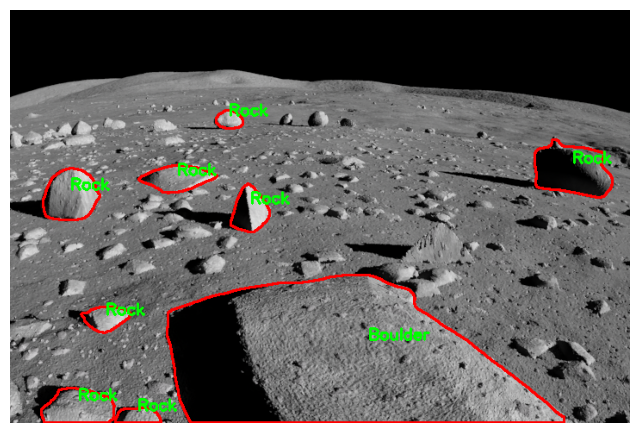

In [8]:

for obj in output['predictions']:
        class_name = obj['class'].capitalize()
        polygon_points = [(p['x'], p['y']) for p in obj['points']]
    
        img=np.array(img)
        img_2 = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        cv2.polylines(img, [np.array(polygon_points, np.int32)], isClosed=True, color=(255,0,0), thickness=2)
        cv2.putText(img, class_name,(int(obj['x']), int(obj['y']-5)) ,cv2.FONT_HERSHEY_SIMPLEX, 0.6,(0,255,0), 2)
plt.figure(figsize=(8,6))
plt.imshow(img)
plt.axis("off")
plt.show()

In [9]:
print("\nSingle Output:")
print(json.dumps(results, indent=4))


Single Output:
{
    "image_features": {
        "craters": {},
        "rocks": {
            "1": {
                "size_m": 34.713109915419565,
                "location": {
                    "x": 69.77889918376351,
                    "y": 215.97860136774761
                },
                "direction_zone": "NW"
            },
            "2": {
                "size_m": 29.0,
                "location": {
                    "x": 110.79778270509978,
                    "y": 358.1330376940133
                },
                "direction_zone": "SW"
            },
            "3": {
                "size_m": 15.890248582070704,
                "location": {
                    "x": 254.5023148148148,
                    "y": 128.12599206349208
                },
                "direction_zone": "NW"
            },
            "4": {
                "size_m": 26.575364531836623,
                "location": {
                    "x": 148.00642730496455,
                    "y